In [ ]:
import time
import copy
import matplotlib.pyplot as plt
from langchain.memory import ConversationBufferMemory
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.callbacks.openai_info import OpenAICallbackHandler

class ChatManager:
    def __init__(self, model_name="gpt-4o-mini"):
        """Initializes the Chat Manager with memory, LLM model, and token tracking."""
        self.model_name = model_name
        self.chat_versions = []
        self.current_version = None

        # ✅ Global storage for ALL token usage across chat versions
        self.token_usage_history = {
            "steps": [],
            "cumulative_tokens": [],
            "cumulative_prompt_tokens": [],
            "cumulative_completion_tokens": [],
            "individual_total_tokens": [],
            "individual_prompt_tokens": [],
            "individual_completion_tokens": []
        }

        self._initialize_llm_and_tracking()

    def _initialize_llm_and_tracking(self):
        """Sets up LLM, memory, and ensures token tracking is updated correctly."""
        self.callback_handler = OpenAICallbackHandler()
        self.llm = ChatOpenAI(model_name=self.model_name, callbacks=[self.callback_handler])
        self.memory = ConversationBufferMemory(return_messages=True)
        self.prompt = self._create_prompt_template()
        self.chain = LLMChain(llm=self.llm, prompt=self.prompt, memory=self.memory, verbose=False)

    def _create_prompt_template(self):
        """Defines the chat prompt format."""
        template = """
        The following is a friendly conversation between an intelligent chatbot and a human.
        Chatbot: {history}
        Human: {input}
        Chatbot:
        """
        return PromptTemplate(template=template, input_variables=["history", "input"])

    def process_user_input(self, user_input):
        """Processes user input, updates chat memory, and tracks token usage."""
        timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        self.chat_versions.append((timestamp, copy.deepcopy(self.memory.chat_memory.messages)))
        self.current_version = len(self.chat_versions) - 1

        result = self.chain.invoke(user_input)
        self._track_token_usage()
        return result

    def _track_token_usage(self, is_reset=False):
        """Tracks token usage while preserving chat history. Handles resets properly."""
        total_used = self.callback_handler.total_tokens
        prompt_used = self.callback_handler.prompt_tokens
        completion_used = self.callback_handler.completion_tokens

        # 🛠️ Get last known cumulative values (before reset)
        prev_total = self.token_usage_history["cumulative_tokens"][-1] if self.token_usage_history["cumulative_tokens"] else 0
        prev_prompt = self.token_usage_history["cumulative_prompt_tokens"][-1] if self.token_usage_history["cumulative_prompt_tokens"] else 0
        prev_completion = self.token_usage_history["cumulative_completion_tokens"][-1] if self.token_usage_history["cumulative_completion_tokens"] else 0

        # 🛠️ Handle Reset Properly
        if is_reset:
            # Instead of resetting to zero, continue tracking smoothly
            self.last_known_cumulative = {
                "total": total_used,
                "prompt": prompt_used,
                "completion": completion_used
            }
            return  # Don't log a new step yet; let the next request handle it correctly

        # Adjust first step after reset to avoid zero dip
        if hasattr(self, "last_known_cumulative"):
            prev_total = self.last_known_cumulative["total"]
            prev_prompt = self.last_known_cumulative["prompt"]
            prev_completion = self.last_known_cumulative["completion"]
            del self.last_known_cumulative  # Ensure it's only used once

        # Ensure no negative values appear
        individual_total = max(0, total_used - prev_total)
        individual_prompt = max(0, prompt_used - prev_prompt)
        individual_completion = max(0, completion_used - prev_completion)

        # Store new token usage values
        steps = len(self.token_usage_history["steps"]) + 1
        self.token_usage_history["steps"].append(steps)
        self.token_usage_history["cumulative_tokens"].append(total_used)
        self.token_usage_history["cumulative_prompt_tokens"].append(prompt_used)
        self.token_usage_history["cumulative_completion_tokens"].append(completion_used)
        self.token_usage_history["individual_total_tokens"].append(individual_total)
        self.token_usage_history["individual_prompt_tokens"].append(individual_prompt)
        self.token_usage_history["individual_completion_tokens"].append(individual_completion)

    def show_chat_versions(self):
        """Displays all chat versions saved so far."""
        print("\n📜 Chat Versions:")
        for i, (timestamp, _) in enumerate(self.chat_versions):
            mark = " (In Use) 🔵" if i == self.current_version else ""
            print(f"Version {i}: {timestamp}{mark}")

    def show_version_messages(self, version_number):
        """Displays all messages from a specific chat version."""
        if 0 <= version_number < len(self.chat_versions):
            print(f"\n🗂️ Messages in Version {version_number}:")
            for i, msg in enumerate(self.chat_versions[version_number][1]):
                print(f"{i}. {msg.type}: {msg.content}")
        else:
            print("⚠️ Invalid version number!")

    def restore_chat_version(self, version_number):
        """Restores a previous chat version while maintaining full token tracking history."""
        if 0 <= version_number < len(self.chat_versions):
            self.memory.clear()  # Fully clear memory before restoring

            for msg in self.chat_versions[version_number][1]:
                if msg.type == "human":
                    self.memory.chat_memory.add_user_message(msg.content)
                else:
                    self.memory.chat_memory.add_ai_message(msg.content)

            self.current_version = version_number
            self._initialize_llm_and_tracking()

            # 🛠️ Reset token usage tracking to avoid negative values
            self._track_token_usage(is_reset=True)

            print(f"✅ Successfully restored to Version {version_number}. Token tracking corrected.")
        else:
            print("⚠️ Invalid version number!")


    def delete_chat_messages(self, indexes_to_delete):
        """Deletes selected messages but keeps full token tracking history."""
        latest_messages = copy.deepcopy(self.memory.chat_memory.messages)

        if not latest_messages:
            print("⚠️ No messages to delete!")
            return

        # 🔹 Ensure we only delete valid indexes
        valid_indexes = [i for i in indexes_to_delete if 0 <= i < len(latest_messages)]
        if not valid_indexes:
            print("⚠️ No valid messages to delete! Operation ignored.")
            return

        # ✅ Log before deletion
        print(f"Deleting indexes: {valid_indexes}. Messages before deletion: {len(latest_messages)}")

        # 🔹 Keep only messages that are NOT being deleted
        new_version_messages = [msg for i, msg in enumerate(latest_messages) if i not in valid_indexes]

        # ✅ Log after deletion
        print(f"Messages after deletion: {len(new_version_messages)}")

        # 🔹 Fully clear memory
        self.memory.clear()
        
        # 🔹 Restore only the remaining messages
        for msg in new_version_messages:
            if msg.type == "human":
                self.memory.chat_memory.add_user_message(msg.content)
            else:
                self.memory.chat_memory.add_ai_message(msg.content)

        # 🔹 Save this new version
        timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        self.chat_versions.append((timestamp, copy.deepcopy(new_version_messages)))
        self.current_version = len(self.chat_versions) - 1

        print(f"✅ Created new version {self.current_version} after deletion! Remaining messages: {len(self.memory.chat_memory.messages)}")

    def show_usage_plots(self):
        """Displays cumulative & per-request token usage plots."""
        fig, axs = plt.subplots(2, 1, figsize=(10, 10))
        axs[0].plot(self.token_usage_history["steps"], self.token_usage_history["cumulative_tokens"], label="Total Tokens", color="blue", marker="o")
        axs[0].plot(self.token_usage_history["steps"], self.token_usage_history["cumulative_prompt_tokens"], label="Prompt Tokens", color="green", marker="o")
        axs[0].plot(self.token_usage_history["steps"], self.token_usage_history["cumulative_completion_tokens"], label="Completion Tokens", color="red", marker="o")
        axs[0].set_title("Cumulative Token Usage")
        axs[0].legend()
        axs[0].grid(True)

        axs[1].bar(self.token_usage_history["steps"], self.token_usage_history["individual_total_tokens"], label="Total Tokens", color="blue", alpha=0.7)
        axs[1].bar(self.token_usage_history["steps"], self.token_usage_history["individual_prompt_tokens"], label="Prompt Tokens", color="green", alpha=0.7)
        axs[1].bar(self.token_usage_history["steps"], self.token_usage_history["individual_completion_tokens"], label="Completion Tokens", color="red", alpha=0.7)
        axs[1].set_title("Token Usage Per Request")
        axs[1].legend()
        axs[1].grid(axis="y", linestyle="--", alpha=0.7)

        plt.tight_layout()
        plt.show()


In [ ]:
chat_manager = ChatManager()


In [ ]:
chat_manager.process_user_input("Hello, how are you?")
chat_manager.process_user_input("Tell me a joke.")
chat_manager.process_user_input("What is AI?")


{'input': 'What is AI?',
 'history': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="Hello! I'm just a bundle of code, but I'm here and ready to chat. How about you? How's your day going?", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Tell me a joke.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='AIMessage(content="Sure! Why did the scarecrow win an award? Because he was outstanding in his field!", additional_kwargs={}, response_metadata={})', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='What is AI?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='AI, or artificial intelligence, refers to the simulation of human intelligence in machines that are programmed to think and learn like humans. This can include processes like problem-solving, understanding natural language, recognizing patterns, and making decisions. Essentially, AI enables com

In [ ]:
chat_manager.show_chat_versions()


📜 Chat Versions:
Version 0: 2025-03-26 09:01:46
Version 1: 2025-03-26 09:01:47
Version 2: 2025-03-26 09:01:49 (In Use) 🔵


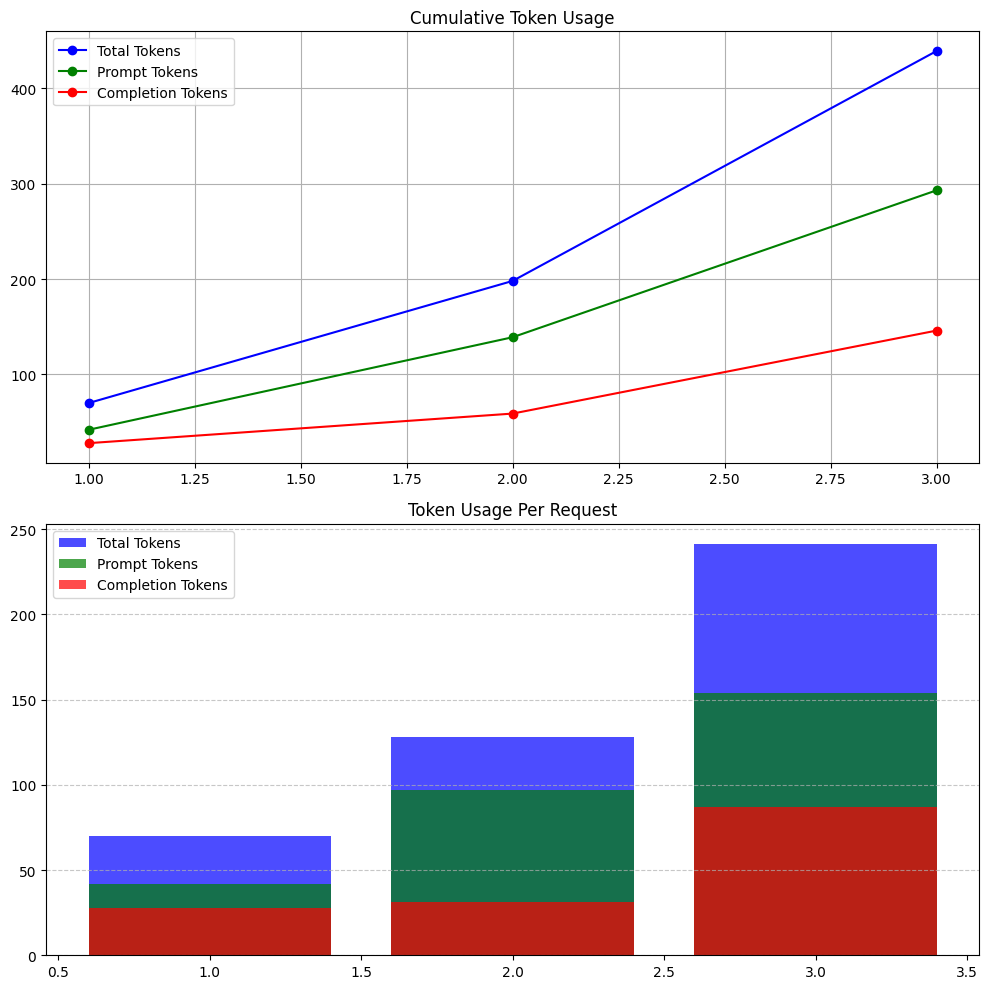

In [258]:
chat_manager.show_usage_plots()

In [ ]:
chat_manager.show_version_messages(0)

In [259]:
chat_manager.restore_chat_version(0)

✅ Successfully restored to Version 0. Token tracking corrected.


In [260]:
print("Memory contents:", chat_manager.memory.chat_memory.messages)

Memory contents: []


In [261]:
chat_manager.process_user_input("Hello, how are you?")
chat_manager.process_user_input("Tell me a joke.")
chat_manager.process_user_input("What is AI?")


{'input': 'What is AI?',
 'history': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How about you? How are you doing today?", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Tell me a joke.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Sure! Here’s one for you: Why did the scarecrow win an award? Because he was outstanding in his field!', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='What is AI?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='AI, or Artificial Intelligence, refers to the simulation of human intelligence in machines that are programmed to think and learn like humans. This can include tasks such as understanding natural language, recognizing patterns, solving problems, and making decisions. There are various types of AI, including narro

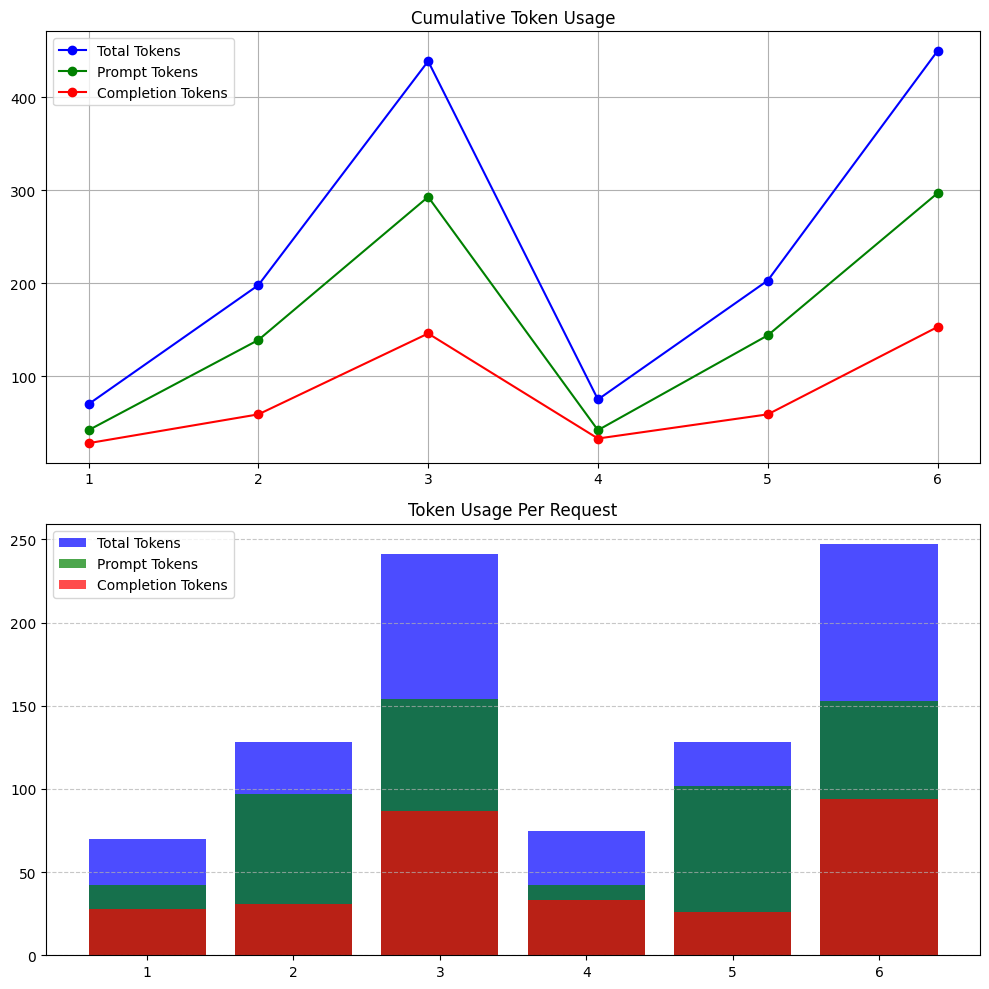

In [262]:
chat_manager.show_usage_plots()

In [242]:
import unittest

# Ensure `ChatManager` is defined in a previous cell before running this
class TestChatManager(unittest.TestCase):

    def setUp(self):
        self.chat_manager = ChatManager()  # Initialize ChatManager

    def test_process_user_input(self):
        """Test processing user input and token tracking."""
        response = self.chat_manager.process_user_input("Hello, how are you?")
        self.assertIn("text", response)  # Ensure 'text' key exists in response
        self.assertGreater(len(self.chat_manager.token_usage_history["steps"]), 0)

    def test_token_tracking_after_restore(self):
        """Ensure token tracking is not lost after restore."""
        self.chat_manager.process_user_input("Test message")
        steps_before = len(self.chat_manager.token_usage_history["steps"])

        self.chat_manager.restore_chat_version(0)

        steps_after = len(self.chat_manager.token_usage_history["steps"])
        self.assertGreaterEqual(steps_after, 1)  # Ensure tokens remain tracked

# ✅ Run unittest in Jupyter Notebook safely
suite = unittest.TestLoader().loadTestsFromTestCase(TestChatManager)
unittest.TextTestRunner().run(suite)


..
----------------------------------------------------------------------
Ran 2 tests in 1.628s

OK


✅ Successfully restored to Version 0. Token tracking corrected.


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

/workspaces/test_chatbot/venv/lib/python3.12/site-packages/langchain_community/chat_models/openai.py:495: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  response = response.dict()
/workspaces/test_chatbot/venv/lib/python3.12/site-packages/langchain_community/chat_models/openai.py:495: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  response = response.dict()
.

Messages before invalid delete: 4
⚠️ No valid messages to delete! Operation ignored.
Messages after invalid delete: 4
Deleting indexes: [3]. Messages before deletion: 4
Messages after deletion: 3
✅ Created new version 2 after deletion! Remaining messages: 3
Messages after valid delete: 3


/workspaces/test_chatbot/venv/lib/python3.12/site-packages/langchain_community/chat_models/openai.py:495: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  response = response.dict()
/workspaces/test_chatbot/venv/lib/python3.12/site-packages/langchain_community/chat_models/openai.py:495: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  response = response.dict()
.

Deleting indexes: [0]. Messages before deletion: 4
Messages after deletion: 3
✅ Created new version 2 after deletion! Remaining messages: 3


/workspaces/test_chatbot/venv/lib/python3.12/site-packages/langchain_community/chat_models/openai.py:495: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  response = response.dict()
.../workspaces/test_chatbot/venv/lib/python3.12/site-packages/langchain_community/chat_models/openai.py:495: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  response = response.dict()
/workspaces/test_chatbot/venv/lib/python3.12/site-packages/langchain_community/chat_models/openai.py:495: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.py

✅ Successfully restored to Version 0. Token tracking corrected.


/workspaces/test_chatbot/venv/lib/python3.12/site-packages/langchain_community/chat_models/openai.py:495: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  response = response.dict()
./workspaces/test_chatbot/venv/lib/python3.12/site-packages/langchain_community/chat_models/openai.py:495: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  response = response.dict()
./workspaces/test_chatbot/venv/lib/python3.12/site-packages/langchain_community/chat_models/openai.py:495: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pyd

⚠️ Invalid version number!


/workspaces/test_chatbot/venv/lib/python3.12/site-packages/langchain_community/chat_models/openai.py:495: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  response = response.dict()
.

✅ Successfully restored to Version 0. Token tracking corrected.


/workspaces/test_chatbot/venv/lib/python3.12/site-packages/langchain_community/chat_models/openai.py:495: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  response = response.dict()
./workspaces/test_chatbot/venv/lib/python3.12/site-packages/langchain_community/chat_models/openai.py:495: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  response = response.dict()
/workspaces/test_chatbot/venv/lib/python3.12/site-packages/langchain_community/chat_models/openai.py:495: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pyda

Deleting indexes: [0]. Messages before deletion: 2
Messages after deletion: 1
✅ Created new version 1 after deletion! Remaining messages: 1


/workspaces/test_chatbot/venv/lib/python3.12/site-packages/langchain_community/chat_models/openai.py:495: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  response = response.dict()


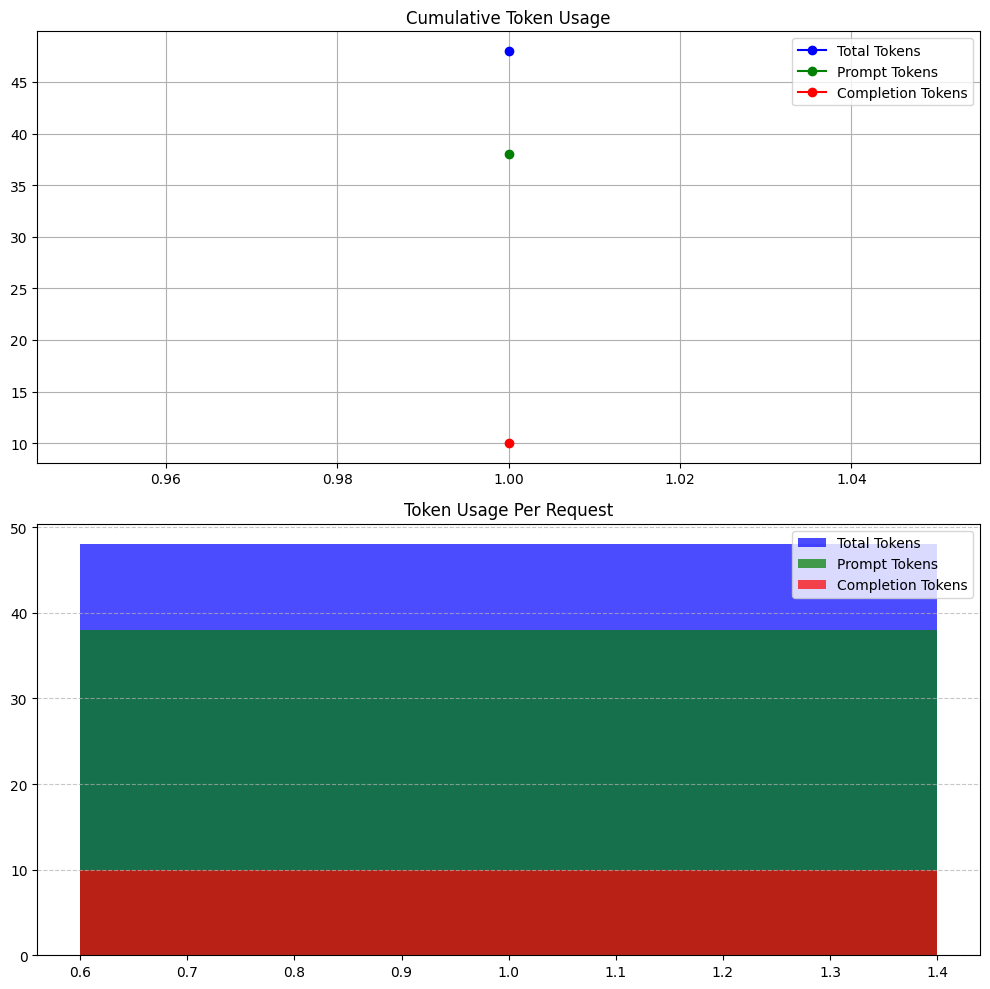

.
----------------------------------------------------------------------
Ran 15 tests in 43.549s

OK


In [263]:
import unittest

class TestChatManager(unittest.TestCase):

    def setUp(self):
        """Initialize a new ChatManager instance for each test."""
        self.chat_manager = ChatManager()

    def test_initialization(self):
        """Test that ChatManager initializes correctly."""
        self.assertIsInstance(self.chat_manager, ChatManager)
        self.assertEqual(self.chat_manager.model_name, "gpt-4o-mini")
        self.assertEqual(len(self.chat_manager.chat_versions), 0)

    def test_process_user_input(self):
        """Test that chatbot responds to user input."""
        response = self.chat_manager.process_user_input("Hello")
        self.assertIsInstance(response["text"], str)
        self.assertTrue(len(response["text"]) > 0)

    def test_multiple_inputs(self):
        """Ensure chatbot processes multiple inputs correctly."""
        self.chat_manager.process_user_input("Hello")
        self.chat_manager.process_user_input("How are you?")
        self.assertGreater(len(self.chat_manager.token_usage_history["steps"]), 1)

    def test_empty_input(self):
        """Test handling of empty user input."""
        response = self.chat_manager.process_user_input("")
        self.assertIsInstance(response["text"], str)

    def test_token_tracking(self):
        """Ensure token usage tracking is updated correctly."""
        self.chat_manager.process_user_input("Hello")
        self.chat_manager.process_user_input("Tell me a joke")
        self.assertGreater(self.chat_manager.token_usage_history["cumulative_tokens"][-1], 0)

    def test_show_chat_versions(self):
        """Test that chat versions are displayed correctly."""
        self.chat_manager.process_user_input("Hi")
        self.assertGreater(len(self.chat_manager.chat_versions), 0)

    def test_restore_chat_version_valid(self):
        """Restore a valid chat version and check memory state."""
        self.chat_manager.process_user_input("Hello")
        self.chat_manager.restore_chat_version(0)
        self.assertEqual(self.chat_manager.current_version, 0)

    def test_restore_chat_version_invalid(self):
        """Test restoring a non-existent chat version."""
        self.chat_manager.restore_chat_version(5)
        self.assertNotEqual(self.chat_manager.current_version, 5)

    def test_delete_valid_messages(self):
        """Delete specific messages and verify they are removed."""
        self.chat_manager.process_user_input("Hello")
        self.chat_manager.process_user_input("What's your name?")
        self.chat_manager.delete_chat_messages([0])  # Delete first message
        self.assertNotIn("Hello", [msg.content for msg in self.chat_manager.memory.chat_memory.messages])

    def test_delete_invalid_messages(self):
        """Test deleting an out-of-range message index."""
        self.chat_manager.process_user_input("Hello")  # Adds 2 messages: Human + AI
        self.chat_manager.process_user_input("How are you?")  # Adds 2 more messages

        # ✅ Log messages before deletion
        print(f"Messages before invalid delete: {len(self.chat_manager.memory.chat_memory.messages)}")

        # Try to delete an invalid message index (e.g., 10)
        self.chat_manager.delete_chat_messages([10])

        # ✅ Check that the messages remain unchanged
        print(f"Messages after invalid delete: {len(self.chat_manager.memory.chat_memory.messages)}")
        self.assertEqual(len(self.chat_manager.memory.chat_memory.messages), 4)

        # ✅ Now delete a valid index (e.g., the last message)
        self.chat_manager.delete_chat_messages([3])
        print(f"Messages after valid delete: {len(self.chat_manager.memory.chat_memory.messages)}")
        self.assertEqual(len(self.chat_manager.memory.chat_memory.messages), 3)


    def test_token_tracking_after_deletion(self):
        """Ensure token tracking is accurate after message deletion."""
        self.chat_manager.process_user_input("Hello")
        before_tokens = self.chat_manager.token_usage_history["cumulative_tokens"][-1]
        self.chat_manager.delete_chat_messages([0])
        after_tokens = self.chat_manager.token_usage_history["cumulative_tokens"][-1]
        self.assertGreaterEqual(after_tokens, before_tokens)

    def test_visualization(self):
        """Test that token usage visualization runs without error."""
        self.chat_manager.process_user_input("Hello")
        try:
            self.chat_manager.show_usage_plots()
            success = True
        except Exception:
            success = False
        self.assertTrue(success)

    def test_multiple_restores_and_inputs(self):
        """Test behavior when restoring multiple versions and continuing chat."""
        self.chat_manager.process_user_input("Hi")
        self.chat_manager.process_user_input("How's the weather?")
        self.chat_manager.restore_chat_version(0)
        self.chat_manager.process_user_input("Tell me a story.")
        self.assertGreater(len(self.chat_manager.memory.chat_memory.messages), 1)

    def test_model_switching(self):
        """Test initializing chat with different models."""
        new_chat_manager = ChatManager(model_name="gpt-4-turbo")
        self.assertEqual(new_chat_manager.model_name, "gpt-4-turbo")

    def test_rapid_inputs(self):
        """Test chatbot behavior under rapid consecutive inputs."""
        inputs = ["Hi", "What's your name?", "Tell me a joke.", "Give me a summary."]
        for msg in inputs:
            self.chat_manager.process_user_input(msg)
        self.assertEqual(len(self.chat_manager.token_usage_history["steps"]), len(inputs))

# Run the tests inside Jupyter Notebook
unittest.main(argv=['first-arg-is-ignored'], exit=False)


In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Simple input box
chat_input = widgets.Text(
    placeholder="Type a message and press Enter..."
)

def chat_callback(change):
    """Handles user input and chatbot response."""
    user_input = change["new"].strip()
    chat_input.value = ""  # Clear input box

    if not user_input:
        return

    print(f"You: {user_input}")  # Display user input
    response = chat_manager.process_user_input(user_input)
    print(f"Bot: {response['text']}\n")  # Display chatbot response

chat_input.observe(chat_callback, names="value")
display(chat_input)


/tmp/ipykernel_82060/2682017125.py:32: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  chat_input.on_submit(chat_callback)


Output()

Text(value='', placeholder='Type your message here...')